# MTH793P - Coursework 8

This is a template notebook for the computational exercises of Coursework 8 of the module MTH793P, Advanced machine learning. 

The goal of this coursework is to explore the Robust-PCA algorithm we discussed in class.

In [1]:
### 
### Required imports
###

import numpy as np
import matplotlib.pyplot as plt

from numpy.testing import assert_almost_equal
from numpy.testing import assert_equal

%matplotlib inline

We start by implementing the thresholding functions that will be used for both algorithms.
* **<font color='red'>shrink</font>**:<br>
Receives a vector/matrix (np.array) **<font color='red'>X</font>**, and a scalar value **<font color='red'>tau</font>**, and returns $S_\tau(X)$. Recall that for a single value $x$, the shrinkage value is given by
$$s_\tau(x) = \begin{cases} x-\tau & x>\tau\\
0 & -\tau \le x \le \tau \\
x+\tau & x < -\tau.\end{cases}$$

* **<font color='red'>svd_threshold</font>**:<br>
Takes a matrix **<font color='red'>X</font>**, and a scalar value **<font color='red'>tau</font>**, and return the SVD thresholded version of **X**, which we denoted as $D_\tau(X)$.<br> Recall that if $X = U\cdot\Sigma\cdot V^T$ then $$D_\tau(X) = U\cdot S_\tau(\Sigma)\cdot V^T$$
When calling **svd** make sure to use **<font color='red'>full_matrices=False</font>**.



In [2]:
def shrink(X, tau):
    ### BEGIN SOLUTION
    X1 = X-tau
    X2 = X+tau
    I1 = np.where(X1 < 0)
    I2 = np.where(X2 > 0)
    X1[I1] = 0
    X2[I2] = 0
    return X1+X2
    ### END SOLUTION

def svd_threshold(X,tau):
    ### BEGIN SOLUTION
    U,S,V = np.linalg.svd(X, full_matrices=False)
    return U@np.diag(shrink(S, tau))@V
    ### END SOLUTION

You can test your functions below.

In [3]:
np.random.seed(443221)
X_test = np.random.rand(3,5)
S_test = shrink(X_test, 0.4)

S_correct = np.array([[0.53844131, 0.        , 0.28450706, 0.08420321, 0.        ],
       [0.        , 0.48604359, 0.07104304, 0.48247663, 0.16975536],
       [0.        , 0.        , 0.        , 0.31094478, 0.00544213]])

assert_almost_equal(S_correct, S_test)

In [4]:
np.random.seed(69493)
X_test = np.random.rand(3,5)
D_test = svd_threshold(X_test, 0.4)

D_correct = np.array([[0.11140963, 0.59401772, 0.40462188, 0.19301507, 0.07600009],
       [0.71593344, 0.69287548, 0.81323569, 0.77775363, 0.70989919],
       [0.34957011, 0.59796082, 0.54558147, 0.41819836, 0.32821505]])

assert_almost_equal(D_correct, D_test)

## ROBUST PCA

In this part we will implement **Roubst PCA** using the **Alternating Direction Method of Multipliers** (ADMM) algorithm we saw in class.<br>
Recall that our objective is to solve:
$$ (L^*,E^*) = \arg\min_{L,E} \|L\|_* + \lambda \|E\|_1\quad\text{subject to}\quad X=L+E.$$
The ADMM algorithm should have the following update iterations:
$$
\begin{split}
L^{(k+1)} &= D_{1/\beta}\left(X-E^{(k)}+\frac{1}{\beta}Y^{(k)}\right),\\
E^{(k+1)} &= S_{\lambda/\beta}\left(X-L^{(k+1)}+\frac{1}{\beta}Y^{(k)}\right),\\
Y^{(k+1)} &= Y^{(k)} + \beta(X-L^{(k+1)}-E^{(k+1)}).
\end{split}
$$
The initial values should be $E^{(0)} = Y^{(0)} = 0$.<br> 
The algorithm should stop after $k$ steps if:
$$ \frac{\|X-L^{(k)}-E^{(k)}\|_F}{\|X\|_F} \le \text{tolerance}.$$


Place your code in the function **<font color='red'>robust_pca</font>** below. It should take the following input:
* **<font color='red'>X</font>** - the input data matrix in $\mathbb{R}^{D\times N}$.
* **<font color='red'>tolerance</font>** - the maximum tolerance to decide when iterations should stop. 
The default value is $10^{-7}$.
* **<font color='red'>beta_val</font>** - a value for the increment size $\beta$.<br>
If **beta_val** is not specified (=None), the default value should be $\frac{D\cdot N}{ 4\|X\|_1}$, where here means
$$\|X\|_1 = \max_{1\le j \le N}\sum_{i=1}^D |X_{ij}|$$
is the largest $\ell_1$ norm among all columns. You can implement it yourself, or use **np.linalg.norm**, with **ord=1**.
* **<font color='red'>lambda_val</font>** - a value for the shrinking size $\lambda$. <br>
If **lambda_val** is not specified (=None), the default value should be $\lambda = 1/\sqrt{M}$ where $M=\max(D,N)$.

* **<font color='red'>max_iter</font>** - maximum number of iterations to run.
* **<font color='red'>iter_print</font>** - how often to print out a progress line.

The output of the function should be the final  **<font color='red'>L, E</font>** (in this order).


In [5]:
def robust_pca(X, tolerance=1e-7, beta_val=None, lambda_val=None, max_iter=10000, iter_print=100):
    ### BEGIN SOLUTION
    
    sh = X.shape
    
    if (beta_val==None):
        beta_val = np.prod(sh) / (4 * np.linalg.norm(X, ord=1))

    if (lambda_val==None):
        lambda_val = 1 / np.sqrt(np.max(sh))

    print(4*np.linalg.norm(X, ord=1))
    print(beta_val)
    print(lambda_val)
    binv = 1/beta_val
    c = 0
    err = np.Inf
    
    Ek = np.zeros(sh)
    Lk = np.zeros(sh)
    Yk = np.zeros(sh)

    while (err > tolerance) and (c < max_iter):
        
        Lk = svd_threshold(X - Ek + binv * Yk, binv)  
        Ek = shrink(X - Lk + binv * Yk, binv*lambda_val)
        Yk = Yk + beta_val * (X - Lk - Ek)
        
        err = np.linalg.norm(X - Lk - Ek)/ np.linalg.norm(X)
        c += 1
        
        if ((c % iter_print) == 0):
            print('iteration: %d, error: %0.10f'% (c, err))
    
    print('DONE. error: %0.10f' % err)
    L = Lk
    E = Ek
    
    ### END SOLUTION
    return L, E

Test your implementation in the following cells.

In [6]:
np.random.seed(32215)
X_test = np.random.rand(3,5)
L_test,E_test = robust_pca(X_test)

L_correct = np.array([[0.01963577, 0.13105536, 0.17630472, 0.3300928 , 0.45559272],
       [0.03492575, 0.12082888, 0.11446813, 0.231619  , 0.32832287],
       [0.06144527, 0.21685941, 0.20898232, 0.42105401, 0.59601344]])

E_correct = np.array([[ 0.        , -0.1055158 ,  0.06658249,  0.02533893,  0.08192902],
       [ 0.        ,  0.72639998,  0.        ,  0.        ,  0.60746671],
       [ 0.14611084,  0.24378236,  0.        ,  0.55088429,  0.2233028 ]])


assert_almost_equal(L_correct, L_test)
assert_almost_equal(E_correct, E_test)

9.170510247758438
1.6356777970633065
0.4472135954999579
iteration: 100, error: 0.0000123507
DONE. error: 0.0000000845


In [7]:
 np.random.seed(23871)
X_test = np.random.rand(11,5)
L_test,E_test = robust_pca(X_test, tolerance=1e-3)

L_correct = np.array([[0.28679088, 0.3782977 , 0.38386958, 0.15774945, 0.2582915 ],
       [0.31483585, 0.22528963, 0.3557005 , 0.11929451, 0.46111774],
       [0.14730494, 0.24898834, 0.21605696, 0.09668534, 0.08174595],
       [0.31153834, 0.29304552, 0.37580819, 0.14090779, 0.39432969],
       [0.36018634, 0.37792535, 0.44811833, 0.17330318, 0.41850579],
       [0.34693628, 0.32673797, 0.41913838, 0.1534881 , 0.43452136],
       [0.26858233, 0.25435662, 0.32448331, 0.12269164, 0.33922262],
       [0.46318543, 0.4210644 , 0.554371  , 0.20039474, 0.59401092],
       [0.1900789 , 0.14670635, 0.21807267, 0.07774768, 0.27163102],
       [0.2438253 , 0.30907201, 0.32239834, 0.12783563, 0.22806527],
       [0.32908993, 0.24941168, 0.37628068, 0.13107769, 0.47189946]])

E_correct = np.array([[ 0.71074568,  0.25265154,  0.        ,  0.10442205, -0.07998331],
       [ 0.363867  , -0.11718184,  0.27815685,  0.        ,  0.        ],
       [ 0.        ,  0.67377127,  0.27963412,  0.12540287, -0.07241076],
       [ 0.05065563,  0.31162903, -0.05130319,  0.        ,  0.25511835],
       [-0.32036074,  0.05904169,  0.40160266,  0.73636894,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.07787628,  0.16485278],
       [ 0.        ,  0.66074105, -0.20447213,  0.08905322,  0.41505434],
       [ 0.        ,  0.        ,  0.04424766, -0.1608632 ,  0.01968977],
       [-0.04988891,  0.        ,  0.        ,  0.67146047,  0.65233295],
       [ 0.61729686,  0.62275123,  0.15431899,  0.        ,  0.        ],
       [ 0.08538039, -0.02976217,  0.        ,  0.43406697,  0.00094181]])


assert_almost_equal(L_correct, L_test)
assert_almost_equal(E_correct, E_test)

22.652491759644658
2.4279889640212704
0.30151134457776363
DONE. error: 0.0009503235


In [8]:
np.random.seed(23871)
X_test = np.random.rand(11,5)

L_test,E_test = robust_pca(X_test, beta_val=0.1, lambda_val = 0.2)
L_correct = np.array([[0.1789972 , 0.18448458, 0.22530562, 0.09978842, 0.17830821],
       [0.15566417, 0.16043625, 0.1959361 , 0.08678058, 0.155065  ],
       [0.1473743 , 0.15189224, 0.18550155, 0.08215909, 0.14680703],
       [0.25058297, 0.2582649 , 0.31541137, 0.13969648, 0.24961844],
       [0.15909524, 0.1639725 , 0.20025482, 0.08869335, 0.15848286],
       [0.20862165, 0.21501721, 0.26259423, 0.11630363, 0.20781864],
       [0.13014024, 0.13412985, 0.16380886, 0.07255135, 0.12963931],
       [0.20862165, 0.21501721, 0.26259423, 0.11630363, 0.20781864],
       [0.14019018, 0.14448788, 0.17645883, 0.07815405, 0.13965057],
       [0.22882091, 0.2358357 , 0.28801924, 0.12756443, 0.22794015],
       [0.21311622, 0.21964957, 0.26825159, 0.11880929, 0.21229591]])

E_correct = np.array([[ 0.81853935,  0.44646466,  0.15915377,  0.16238308,  0.        ],
       [ 0.52303867, -0.05232846,  0.43792126,  0.03107459,  0.30614591],
       [ 0.        ,  0.77086737,  0.31018953,  0.13992912, -0.13747184],
       [ 0.111611  ,  0.34640965,  0.00909363,  0.        ,  0.3998296 ],
       [-0.11926963,  0.27299454,  0.64946617,  0.82097877,  0.2599611 ],
       [ 0.13779749,  0.11241793,  0.15641711, -0.04069182,  0.3915555 ],
       [ 0.13802619,  0.78096782, -0.04379768,  0.13919351,  0.62463765],
       [ 0.25457015,  0.2061539 ,  0.33602443, -0.07677209,  0.40588206],
       [ 0.        ,  0.        ,  0.04339786,  0.6710541 ,  0.7843134 ],
       [ 0.63230124,  0.69598755,  0.18869808,  0.        ,  0.        ],
       [ 0.2013541 ,  0.        ,  0.10764006,  0.44633537,  0.26054537]])

assert_almost_equal(L_correct, L_test)
assert_almost_equal(E_correct, E_test)

22.652491759644658
0.1
0.2
iteration: 100, error: 0.0026761816
iteration: 200, error: 0.0013615642
iteration: 300, error: 0.0007670493
iteration: 400, error: 0.0004343937
iteration: 500, error: 0.0002471554
iteration: 600, error: 0.0001411977
iteration: 700, error: 0.0000809375
iteration: 800, error: 0.0000465215
iteration: 900, error: 0.0000267977
iteration: 1000, error: 0.0000154626
iteration: 1100, error: 0.0000089340
iteration: 1200, error: 0.0000051673
iteration: 1300, error: 0.0000029911
iteration: 1400, error: 0.0000017325
iteration: 1500, error: 0.0000010040
iteration: 1600, error: 0.0000005821
iteration: 1700, error: 0.0000003375
iteration: 1800, error: 0.0000001958
iteration: 1900, error: 0.0000001136
DONE. error: 0.0000000997


Our next goal is ot test the Robust-PCA algorithm on noisy images. First, we  have code that adds noise to a picture (matrix). <br> We will use the following two functions (already coded):<br>
* **<font color='red'>noise_patch</font>** - given a matrix **X** and values **R** and **C**, places random values in the first **R x C** "corner" of the matrix, replacing the original values.
* **<font color='red'>noise_rand</font>** - given a matrix **X** and a probability **P**, every element in **X** is replaced with probability **P** with a new random value (between 0 and 1).

In [9]:
def noise_patch(X, R, C):
    Xnew = np.array(X)
    Xnew[0:R, 0:C] = np.random.rand(R,C)
    return Xnew
    
def noise_rand(X, P):
    Xnew = np.array(X) 
    R1 = np.random.rand(X.shape[0], X.shape[1])
    R2 = np.random.rand(X.shape[0], X.shape[1])
    IDX = np.where(R1<P)
    Xnew[IDX] = R2[IDX]
    return Xnew

Write a function **<font color='red'>im_noise</font>** that  takes an image **<font color='red'>im</font>** and generates **two** noisy versions of that image, in the following way:
   
* **<font color='red'>im_patch</font>** - takes the original image and replaces the first **W x H** patch with random values.
* **<font color='red'>im_rand</font>** - takes the original image and replaces each pixel with a random value, with probability **P**. 

Your code should use the functions **noise_patch** and **noise_rand** above. 

**<font color='red'>NOTE:</font>** We want the two images to contain roughly **the same number of noisy pixels**. <br>Therefore, we want the probability **P** to be equal to $$P=\frac{\text{patch-size}}{\text{image-size}}$$
For example, if the noisy patch covers a quarter of the image, we take **P=1/4**.



In [10]:
def im_noise(im, W, H):
    ### BEGIN SOLUTION
    D,N = im.shape
    P = W*H/(N*D)
    
    im_patch = noise_patch(im, W, H)
    im_rand = noise_rand(im, P) 
    print(P)
    ### END SOLUTION
    return im_patch, im_rand

The code below tests that the percentage of noisy pixels in each of the images is correct.

In [11]:
N_test = 1000
W_test = 123
H_test = 456

im_test = np.zeros([N_test,N_test])
im_patch_test, im_rand_test = im_noise(im_test, W_test, H_test)

P_1 = np.count_nonzero(im_patch_test) / N_test**2
P_2 = np.count_nonzero(im_rand_test) / N_test**2
P_correct = 0.056088

assert_equal(P_1, P_correct)
assert_almost_equal(P_2, P_correct, decimal=3)

### DO NOT REMOVE/EDIT THIS CELL ###
### BEGIN HIDDEN TESTS 
np.random.seed(98982)
im_test = np.random.rand(6,8)
im_patch_test, im_rand_test = im_noise(im_test, 4,5)

im_patch_correct_1 = np.array([[0.68437726, 0.13345073, 0.85150184, 0.62981751, 0.21143548,
        0.1887726 , 0.71913838, 0.86013021],
       [0.90897888, 0.95699582, 0.15236318, 0.19566467, 0.74230093,
        0.46245291, 0.56234759, 0.89131541],
       [0.5675763 , 0.5764257 , 0.37151332, 0.44188513, 0.38251421,
        0.24039983, 0.20154136, 0.24338346],
       [0.66795653, 0.04095096, 0.82950215, 0.06941317, 0.00917371,
        0.14473991, 0.02034292, 0.46413538],
       [0.47992972, 0.58258691, 0.22891602, 0.97189115, 0.5372407 ,
        0.13937257, 0.63955282, 0.45154579],
       [0.98637548, 0.50608729, 0.16976207, 0.90493301, 0.25875341,
        0.83205942, 0.67447397, 0.12676837]])

im_rand_correct_1 = np.array([[0.00977421, 0.06731354, 0.68559457, 0.19923948, 0.17425577,
        0.1887726 , 0.71913838, 0.25084934],
       [0.29004759, 0.86193975, 0.8390279 , 0.67564299, 0.0211911 ,
        0.46245291, 0.17630645, 0.89131541],
       [0.03212421, 0.25612454, 0.61340447, 0.55024333, 0.72125106,
        0.8783779 , 0.58793133, 0.99131946],
       [0.65410586, 0.83339829, 0.37107578, 0.51547922, 0.77526025,
        0.14473991, 0.71213108, 0.49798474],
       [0.49806896, 0.58258691, 0.22891602, 0.97189115, 0.5372407 ,
        0.13937257, 0.63955282, 0.09808884],
       [0.52801619, 0.50608729, 0.16976207, 0.90493301, 0.25875341,
        0.83205942, 0.67447397, 0.12676837]])

im_patch_correct_2 = np.array([[0.47640497, 0.59343581, 0.71213108, 0.49798474, 0.49806896,
        0.1887726 , 0.71913838, 0.86013021],
       [0.69432607, 0.45709576, 0.60310766, 0.76537623, 0.08319777,
        0.46245291, 0.56234759, 0.89131541],
       [0.50569773, 0.09808884, 0.52801619, 0.00393647, 0.16987423,
        0.24039983, 0.20154136, 0.24338346],
       [0.58340426, 0.67273258, 0.82233646, 0.12173915, 0.02942476,
        0.14473991, 0.02034292, 0.46413538],
       [0.47992972, 0.58258691, 0.22891602, 0.97189115, 0.5372407 ,
        0.13937257, 0.63955282, 0.45154579],
       [0.98637548, 0.50608729, 0.16976207, 0.90493301, 0.25875341,
        0.83205942, 0.67447397, 0.12676837]])

im_rand_correct_2 = np.array([[0.66570912, 0.83351442, 0.68559457, 0.65740592, 0.19367012,
        0.1887726 , 0.71913838, 0.53557686],
       [0.44459746, 0.86193975, 0.49887942, 0.88849042, 0.3473238 ,
        0.46245291, 0.69254731, 0.89131541],
       [0.56661749, 0.69821731, 0.81809672, 0.88601429, 0.00977421,
        0.24039983, 0.20154136, 0.19923948],
       [0.65410586, 0.83339829, 0.37107578, 0.25084934, 0.29004759,
        0.14473991, 0.8390279 , 0.67564299],
       [0.47992972, 0.58258691, 0.17630645, 0.97189115, 0.03212421,
        0.25612454, 0.63955282, 0.45154579],
       [0.98637548, 0.8783779 , 0.58793133, 0.99131946, 0.25875341,
        0.83205942, 0.67447397, 0.12676837]])

F = 0
try:
    assert_almost_equal(im_patch_test, im_patch_correct_1)
    assert_almost_equal(im_rand_test, im_rand_correct_1)
    F = 1
except: 
    pass

try:
    assert_almost_equal(im_patch_test, im_patch_correct_2)
    assert_almost_equal(im_rand_test, im_rand_correct_2)
    F = 1
except: 
    pass

assert_equal(F,1)

### END HIDDEN TESTS

0.056088
0.4166666666666667


We will test the algorithm on a single image from the Yale database.<br>
You are encouraged to change the image file and see the behavior on different pictures.<br>
Make sure to set it back to **'face.png'** before submitting.

In [12]:
im = plt.imread('face.png')
im = im[:,:,0]

Use **im_noise** to generate two noisy version of the image, using a **<font color='red'>70 x 40</font>** patch size.<br>
Place the resulting images in the variables called **<font color='red'>im_patch</font>**  and **<font color='red'>im_rand</font>**.

In [13]:
### BEGIN SOLUTION
im_patch, im_rand = im_noise(im, 70, 40)
### END SOLUTION

0.08680555555555555


Here we present the original image with the two noisy version.

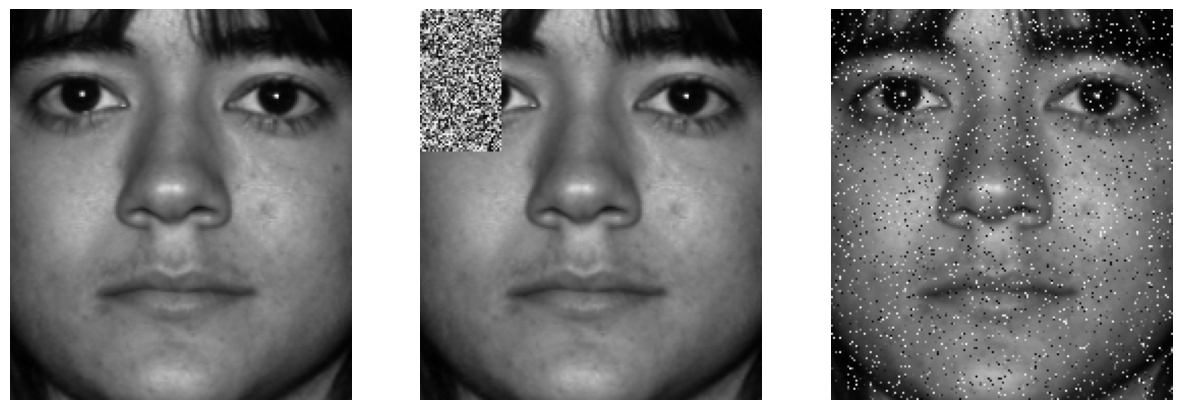

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(im,cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(im_patch,cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(im_rand,cmap='gray')
plt.axis('off');

Call the **<font color='red'>robust_pca</font>** function to decompose each of the noisy images into two a **low-rank** and **sparse** parts.<br>
The low-rank parts should be named **<font color='red'>L_patch</font>** and **<font color='red'>L_rand</font>**, and the sparse parts should be named **<font color='red'>E_patch</font>** and **<font color='red'>E_rand</font>**.

You are enocuraged to try different input parameter values for **robust_pca**.<br>

In [15]:
### BEGIN SOLUTION
L_patch, E_patch= robust_pca(im_patch)
L_rand, E_rand = robust_pca(im_rand)
### END SOLUTION

415.62347412109375
77.60870597651102
0.07216878364870323
iteration: 100, error: 0.0000118112
iteration: 200, error: 0.0000099973
iteration: 300, error: 0.0000080469
iteration: 400, error: 0.0000051380
iteration: 500, error: 0.0000040556
iteration: 600, error: 0.0000029009
iteration: 700, error: 0.0000022059
iteration: 800, error: 0.0000017182
iteration: 900, error: 0.0000011737
iteration: 1000, error: 0.0000008020
iteration: 1100, error: 0.0000006024
iteration: 1200, error: 0.0000005644
iteration: 1300, error: 0.0000004058
iteration: 1400, error: 0.0000005551
iteration: 1500, error: 0.0000002689
iteration: 1600, error: 0.0000002082
iteration: 1700, error: 0.0000002306
iteration: 1800, error: 0.0000001392
iteration: 1900, error: 0.0000001087
DONE. error: 0.0000000999
414.70849609375
77.77993531318474
0.07216878364870323
iteration: 100, error: 0.0000252113
iteration: 200, error: 0.0000267494
iteration: 300, error: 0.0000179924
iteration: 400, error: 0.0000052813
iteration: 500, error: 0.

We present the output **L**'s **E**'s and **(L+E)**'s.

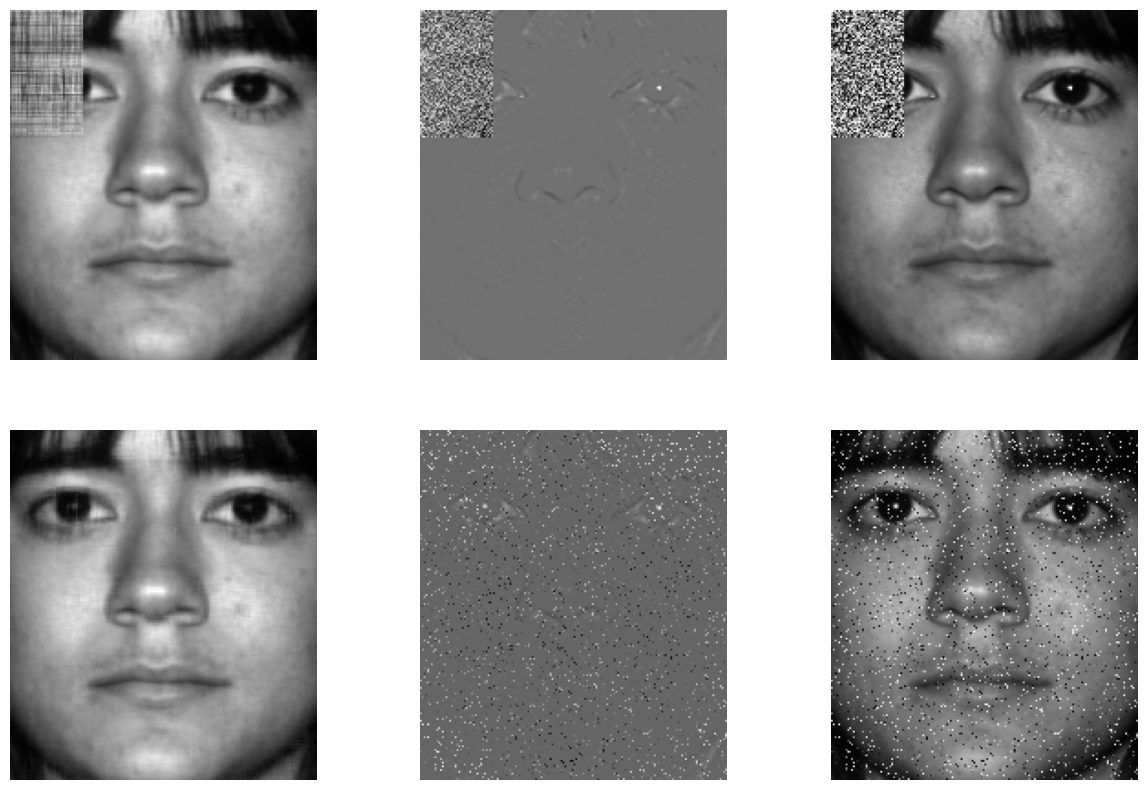

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(L_patch, cmap='gray')
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(E_patch, cmap='gray')
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(L_patch+E_patch, cmap='gray')
plt.axis('off')


plt.subplot(2,3,4)
plt.imshow(L_rand, cmap='gray')
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(E_rand, cmap='gray')
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(L_rand+E_rand, cmap='gray')
plt.axis('off');

Look at the resulting images, and try to understand what you ovserve in each of them.

Try to repeat the experiment above with different patch sizes, to better appreicate the results.<br>


